# LSTM Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from dataclasses import dataclass
from typing import Union, Tuple, List

2022-12-02 13:05:12.207581: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 13:05:12.353322: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-02 13:05:12.353341: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-02 13:05:12.384461: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-02 13:05:13.521051: W tensorflow/stream_executor/platform/de

In [2]:
# Read the data.
df = pd.read_csv('smoothed_data_kansas.csv')
x = np.concatenate((df['x_19'], df['x_20'], df['x_22']), axis=0)
# NDVI time series.
y = np.concatenate((df['y_19'], df['y_20'], df['y_22']), axis=0)
# Generate the time vector in days after planting.
time = [i for i in range(len(y))]

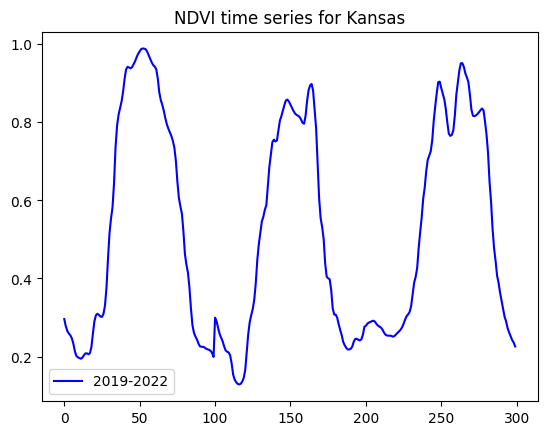

In [3]:
plt.title('NDVI time series for Kansas')
plt.plot(time, y, 'b', label='2019-2022')
plt.legend()
plt.show()

In [4]:
#df["y_23"] = df[["y_19", "y_20", "y_21"]].mean(axis=1)
#y = np.concatenate((df['y_19'], df['y_20'], df['y_22'], df["y_23"]), axis=0)
#time = [i for i in range(len(y))]
#plt.title('NDVI time series for Kansas')
#plt.plot(time, y, 'b', label='2019-2022')
#plt.plot(time[300:], df["y_23"], label="Prediction", color="red")
#plt.legend()
#plt.show()

In [5]:
#plt.plot(list(df["y_22"]), label="Original")
#plt.plot(list(df["y_23"]), label="Naive Model")
#plt.legend()

In [6]:
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import mean_absolute_error
#
#evaluation = df[["y_19", "y_20", "y_22"]]
#evaluated = df["y_23"]
#
#for column in evaluation.columns:
#    rmse = np.sqrt(mean_squared_error(evaluation[column], evaluated))
#    mae = mean_absolute_error(evaluation[column], evaluated)
#    print(rmse)
#    print(mae)
#    print(".........................................")

In [7]:
#print(np.sqrt(0.002503))

In [8]:
# Time series parameters.
@dataclass
class PARAMETERS:
  TIME, SERIES = time, y
  # Number of days to be used on the training set.
  SPLIT_TIME = 200
  # Data points to make our prediction.
  WINDOW_SIZE = 25
  # How many items will we supply per batch.
  BATCH_SIZE = 32
  # Define the Tensorflow sample buffer.
  SHUFFLE_BUFFER_SIZE = 1000
  # Number of epochs.
  EPOCHS = 50
  # Next t steps to predeict.
  PREDICT_STEPS = 100
  # Acceptable error threshold
  THRESHOLD = 0.04

In [9]:
def train_val_split(
  time: Union[List, np.ndarray],
  series: Union[List, np.ndarray],
  time_step: int = PARAMETERS.SPLIT_TIME
) -> Tuple[np.ndarray, ...]:
  """
  Divide the time series into training and validation set.
  """
  assert isinstance(time, (np.ndarray, list))
  
  # Training time vector.
  time_train = time[:time_step]
  # NDVI series vector.
  series_train = series[:time_step]
  # Validation time vector.
  time_valid = time[time_step:]
  # NDVI series vector.
  series_valid = series[time_step:]
  
  return time_train, series_train, time_valid, series_valid

def windowed_dataset(
	series: Union[List, np.ndarray],
	window_size: int = PARAMETERS.WINDOW_SIZE,
	batch_size: int = PARAMETERS.BATCH_SIZE,
	shuffle_buffer: int = PARAMETERS.SHUFFLE_BUFFER_SIZE
) -> tf.data.Dataset:
	"""
	We create time windows to create X and y features.
	For example, if we choose a window of 30, we will create a dataset formed by 30 points as X
	"""
	# Create a TensorFlow dataset from np.arrays or lists.
	dataset = tf.data.Dataset.from_tensor_slices(series)
	# Create a DataFrame of windows.
	dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
	# Flat the vectors and make batches of the data.
	dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
	# Randomly shuffle the data.
	dataset = dataset.shuffle(shuffle_buffer)
	# Transform the data to the format X, y.
	dataset = dataset.map(lambda window: (window[:-1], window[-1]))
	# Prefetch.
	dataset = dataset.batch(batch_size).prefetch(1)
	return dataset

In [10]:
# Split the data into training and validation set
time_train, series_train, time_valid, series_valid = train_val_split(PARAMETERS.TIME, PARAMETERS.SERIES)

In [11]:
# Create the dataset with time windows.
dataset = windowed_dataset(series_train)

2022-12-02 13:05:15.254215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-02 13:05:15.254350: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-02 13:05:15.254416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-02 13:05:15.254465: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-02 13:05:15.254508: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [12]:
class EarlyStopping(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < PARAMETERS.THRESHOLD):
      print("\nMAEthreshold reached. Training stopped.")
      self.model.stop_training = True

# Let's create an object of our class and assign it to a variable
early_stopping = EarlyStopping()

In [13]:
def create_model():
  """
  Function to define a sequential model.
  Appropriate for a plain stack of layers where 
  each layer has exactly ONE input tensor and ONE output tensor.
  """
  # Set a random seed.
  tf.random.set_seed(51)

  # Uncompiled model.
  model = tf.keras.models.Sequential([
      # Lambda layer to handle the input data format. 
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                              input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      # Layer of prediction.
      tf.keras.layers.Dense(1),
  ])
  
  # Compile model for training.
  model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
  )

  return model

In [14]:
# Call and create the model.
model = create_model()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 2048)       8404992   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 1024)       10489856  
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 512)        2623488   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 256)        656384    
 nal)                                                   

In [16]:
# Training and assign the callback
history = model.fit(dataset, epochs=PARAMETERS.EPOCHS, callbacks=[early_stopping])

Epoch 1/50
6/6 [==============================] - 19s 1s/step - loss: 0.1620 - mae: 0.4719
Epoch 2/50
6/6 [==============================] - 7s 1s/step - loss: 0.0369 - mae: 0.2164
Epoch 3/50
6/6 [==============================] - 7s 1s/step - loss: 0.0215 - mae: 0.1759
Epoch 4/50
6/6 [==============================] - 8s 1s/step - loss: 0.0107 - mae: 0.1175
Epoch 5/50
6/6 [==============================] - 7s 1s/step - loss: 0.0048 - mae: 0.0798
Epoch 6/50
6/6 [==============================] - 7s 1s/step - loss: 0.0032 - mae: 0.0634
Epoch 7/50
6/6 [==============================] - 7s 1s/step - loss: 0.0024 - mae: 0.0548
Epoch 8/50
6/6 [==============================] - 7s 1s/step - loss: 0.0019 - mae: 0.0470
Epoch 9/50
6/6 [==============================] - 8s 1s/step - loss: 0.0016 - mae: 0.0440
Epoch 10/50
6/6 [==============================] - 8s 1s/step - loss: 0.0019 - mae: 0.0500
Epoch 11/50
6/6 [==============================] - 7s 1s/step - loss: 0.0021 - mae: 0.0513
Epoch 1

In [17]:
def compute_metrics(
  true_series : Union[List, np.ndarray],
  forecast : Union[List, np.ndarray]
) -> Tuple[float, float]:
  """
  Print MSE and MAE
  """
  mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
  mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

  return mse, mae

In [18]:
def model_forecast(
  model, 
  series: np.ndarray, 
  window_size: int
) -> np.ndarray:
  """
  Converts the input series into a dataset with time windows for forecasting.
  """
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  
  return forecast

In [19]:
# Prediction on the whole series.
all_forecast = model_forecast(model, PARAMETERS.SERIES, PARAMETERS.WINDOW_SIZE).squeeze()

# Validation portion.
val_forecast = all_forecast[PARAMETERS.SPLIT_TIME - PARAMETERS.WINDOW_SIZE:-1]

9/9 [==============================] - 5s 306ms/step


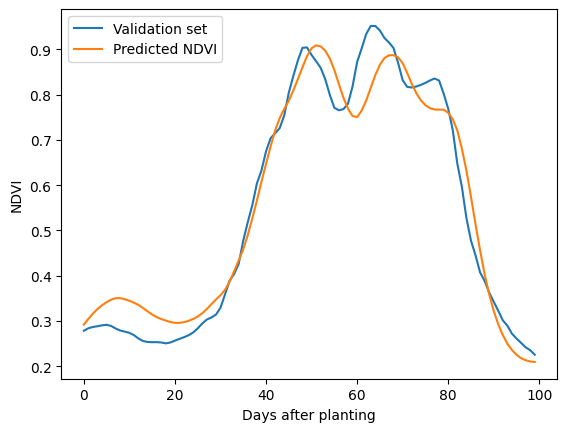

In [20]:
plt.plot(series_valid[:100], label="Validation set")
plt.plot(val_forecast[:100], label="Predicted NDVI")
plt.xlabel("Days after planting")
plt.ylabel("NDVI")
plt.legend()
plt.show()

In [21]:
mse, mae = compute_metrics(series_valid, val_forecast)
print(f"mse: {mse:5f}, mae: {mae:5f}")

mse: 0.002805, mae: 0.043611


In [22]:
# Get the forecast of the model.
new_forecast = []

for i in range(PARAMETERS.PREDICT_STEPS):
  new_forecast_series = PARAMETERS.SERIES[-PARAMETERS.WINDOW_SIZE:]  
  pred = model.predict(new_forecast_series[np.newaxis])
  new_forecast.append(pred.reshape(-1))
  PARAMETERS.SERIES = np.append(PARAMETERS.SERIES, pred)

# Crete the new time vector.
new_time = [i for i in range(len(PARAMETERS.TIME) + 1, len(PARAMETERS.TIME) + PARAMETERS.PREDICT_STEPS + 1)]

1/1 [==============================] - 0s 79ms/step


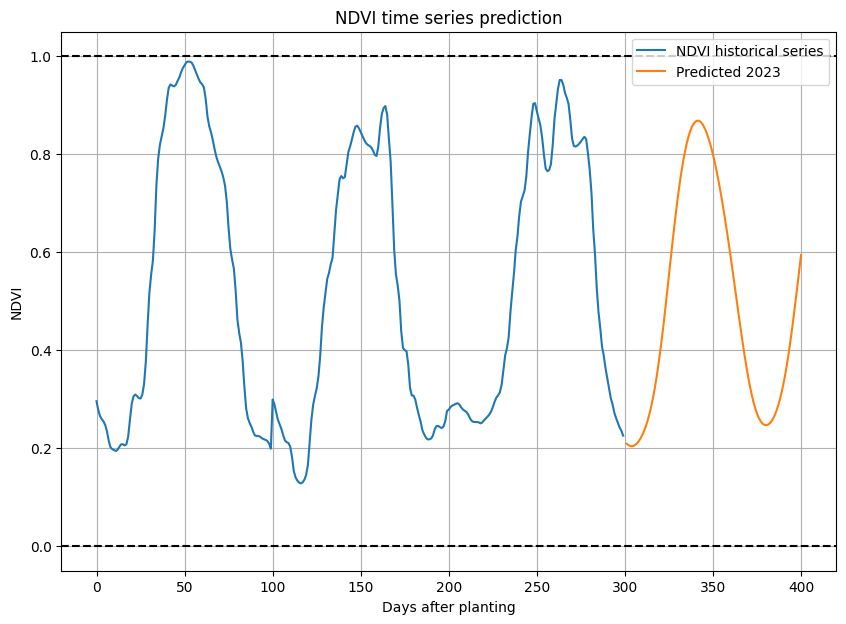

In [23]:
plt.figure(figsize=(10, 7))
plt.title('NDVI time series prediction')
plt.plot(PARAMETERS.TIME[:300], PARAMETERS.SERIES[:300], color='tab:blue', label='NDVI historical series')
plt.plot(new_time, new_forecast, color='tab:orange', label='Predicted 2023')
plt.axhline(y = 1, color = 'black', linestyle = '--')
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.xlabel('Days after planting')
plt.ylabel('NDVI')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [24]:
# Read the data.
df_ = pd.read_csv('smoothed_data_Kansas2.csv')
x_ = np.concatenate((df['x_19'], df['x_20'], df['x_22']), axis=0)
# NDVI time series.
y_ = np.concatenate((df['y_19'], df['y_20'], df['y_22']), axis=0)
# Generate the time vector in days after planting.
time_ = [i for i in range(len(y_))]

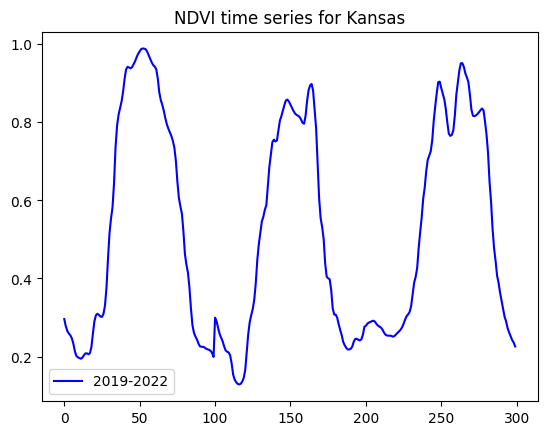

In [25]:
plt.title('NDVI time series for Kansas')
plt.plot(time_, y_, 'b', label='2019-2022')
plt.legend()
plt.show()

In [26]:
# Get the forecast of the model.
new_forecast_ = []

for i in range(PARAMETERS.PREDICT_STEPS):
  new_forecast_series = y_[-PARAMETERS.WINDOW_SIZE:]  
  pred = model.predict(new_forecast_series[np.newaxis])
  new_forecast.append(pred.reshape(-1))
  y_ = np.append(y_, pred)

# Crete the new time vector.
new_time_ = [i for i in range(PARAMETERS.PREDICT_STEPS + 1)]

1/1 [==============================] - 0s 72ms/step


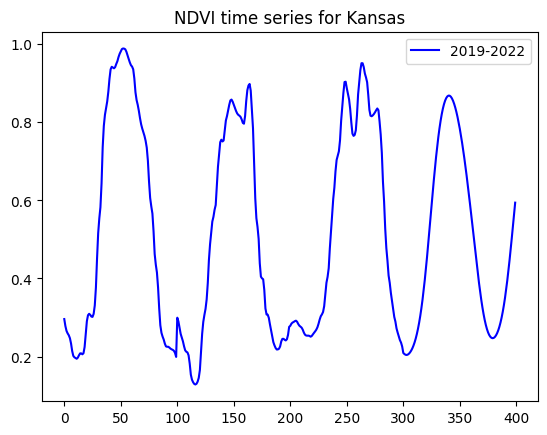

In [27]:
plt.title('NDVI time series for Kansas')
plt.plot(y_, 'b', label='2019-2022')
plt.legend()
plt.show()